# Recommend destinations based on collaborative filtering 

## Step 1: Import the Dependencies

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

## Step 2: Load the Data

In [2]:
destinations = pd.read_csv("sample_destinations.csv")
destinations.head()

,destination_id,title,genre,history,art_and_architecture,nature,adventure,entertainment,health_and_lifestyle,food,industries,religious
0,0,Boudhanath Stupa,['Religious Sites'],True,True,False,False,False,False,False,False,True
1,1,Phewa Tal (Fewa Lake),['Bodies of Water'],False,False,True,False,False,False,False,False,False
2,2,Sarangkot,['Mountains'],False,False,True,False,False,False,False,False,False
3,3,Swayambhunath Temple,['Religious Sites'],True,True,False,False,False,False,False,False,True
4,4,Poon Hill,['Mountains'],False,False,True,False,False,False,False,False,False


In [3]:
ratings=pd.read_csv("sample_user_ratings.csv")
ratings.head()

,user_id,destination_id,rating
0,0,62,5
1,0,120,4
2,0,28,4
3,0,4,5
4,0,100,3


## Step 3: Exploratory Data Analysis


In [4]:
n_ratings = len(ratings)
n_destinations = ratings['destination_id'].nunique() #unique rated destinations
n_users = ratings['user_id'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique rated destination_id's: {n_destinations}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per destination: {round(n_ratings/n_destinations, 2)}")

Number of ratings: 2000
Number of unique rated destination_id's: 200
Number of unique users: 101
Average number of ratings per user: 19.8
Average number of ratings per destination: 10.0


Now, let's take a look at users' rating counts. We can do this using pandas' `groupby()` and `count()` which groups the data by `user_id`'s and counts the number of ratings for each userId. 

In [5]:
user_freq = ratings[['user_id', 'destination_id']].groupby('user_id').count().reset_index()
user_freq.columns = ['user_id', 'n_ratings']
user_freq.head()

,user_id,n_ratings
0,0,24
1,1,14
2,2,20
3,3,26
4,4,22


In [6]:
print(f"Mean number of ratings for a given user: {user_freq['n_ratings'].mean():.2f}.")

Mean number of ratings for a given user: 19.80.


### Destinations with the lowest and highest average rating

In [7]:
mean_rating = ratings.groupby('destination_id')[['rating']].mean()

lowest_rated = mean_rating['rating'].idxmin()
destinations[destinations['destination_id'] == lowest_rated]

,destination_id,title,genre,history,art_and_architecture,nature,adventure,entertainment,health_and_lifestyle,food,industries,religious
131,131,Mera Peak,['Mountains'],False,False,True,False,False,False,False,False,False


In [8]:
highest_rated = mean_rating['rating'].idxmax()
destinations[destinations['destination_id'] == highest_rated]

,destination_id,title,genre,history,art_and_architecture,nature,adventure,entertainment,health_and_lifestyle,food,industries,religious
11,11,Golden Temple (Hiranya Varna Mahavihar),['Religious Sites'],True,True,False,False,False,False,False,False,True


In [9]:
ratings[ratings['destination_id']==highest_rated]

,user_id,destination_id,rating
846,41,11,5
931,46,11,5
1047,52,11,5
1655,82,11,5
1941,97,11,5


Better approach is to look at the [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average).

#### Bayesian Average

Bayesian Average is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for destination $i$. In this case, our prior will be the average rating across all destinations. By defintion, C represents "the typical dataset size". Let's make $C$ be the average number of ratings for a given destination.

In [10]:
destination_stats = ratings.groupby('destination_id')[['rating']].agg(['count', 'mean'])
destination_stats.columns = destination_stats.columns.droplevel()
destination_stats

,count,mean
destination_id,,
0,9,4.555556
1,9,4.333333
2,15,4.466667
3,5,4.600000
4,8,4.750000
...,...,...
195,6,2.833333
196,11,3.000000
197,12,3.000000


In [11]:
C = destination_stats['count'].mean()
m = destination_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('destination_id')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['destination_id', 'bayesian_avg']
destination_stats = destination_stats.merge(bayesian_avg_ratings, on='destination_id')

In [12]:
destination_stats = destination_stats.merge(destinations[['destination_id', 'title']])
destination_stats.sort_values('bayesian_avg', ascending=False).head()

,destination_id,count,mean,bayesian_avg,title
58,58,18,4.722222,4.379142,Langtang Valley
30,30,16,4.687500,4.331384,Muktinath Temple
74,74,13,4.769231,4.331129,Babar Mahal Revisted
67,67,13,4.769231,4.331129,Tushita-Nepal
86,86,11,4.818182,4.315047,Makwanpur Gadhi


### Destinations with the least Bayesian averages 

In [13]:
destination_stats.sort_values('bayesian_avg', ascending=True).head()

,destination_id,count,mean,bayesian_avg,title
184,184,12,2.416667,3.027999,Image Ark
132,132,9,2.333333,3.085051,Akash Bhairav Temple
139,139,18,2.777778,3.129142,Sauraha Tharu Culture House
180,180,13,2.692308,3.157216,Dattatreya Temple
111,111,12,2.666667,3.164363,Rara Lake


### Destinations with the highest Bayesian averages

In [14]:
destination_stats.sort_values('bayesian_avg', ascending=False).head()

,destination_id,count,mean,bayesian_avg,title
58,58,18,4.722222,4.379142,Langtang Valley
30,30,16,4.687500,4.331384,Muktinath Temple
74,74,13,4.769231,4.331129,Babar Mahal Revisted
67,67,13,4.769231,4.331129,Tushita-Nepal
86,86,11,4.818182,4.315047,Makwanpur Gadhi


## Step 4: Transforming the data

We will be using a technique called [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) to generate user recommendations. This technique is based on the assumption of "homophily" - similar users like similar things. Collaborative filtering is a type of unsupervised learning that makes predictions about the interests of a user by learning from the interests of a larger population.

The first step of collaborative filtering is to transform our data into a `user-item matrix` - also known as a "utility" matrix. In this matrix, rows represent users and columns represent items. The beauty of collaborative filtering is that it doesn't require any information about the users or items to generate recommendations. 



The `create_X()` function outputs a sparse matrix X with four mapper dictionaries:
- **user_mapper:** maps user id to user index
- **movie_mapper:** maps movie id to movie index
- **user_inv_mapper:** maps user index to user id
- **movie_inv_mapper:** maps movie index to movie id

We need these dictionaries because they map which row and column of the utility matrix corresponds to which user ID and movie ID, respectively.

The **X** (user-item) matrix is a [scipy.sparse.csr_matrix](scipylinkhere) which stores the data sparsely.

In [15]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        destination_mapper: dict that maps destination id's to movie indices
        destination_inv_mapper: dict that maps destination indices to movie id's
    """
    N = df['user_id'].nunique()
    M = df['destination_id'].nunique()

    user_mapper = dict(zip(np.unique(df["user_id"]), list(range(N))))
    destination_mapper = dict(zip(np.unique(df["destination_id"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["user_id"])))
    destination_inv_mapper = dict(zip(list(range(M)), np.unique(df["destination_id"])))
    
    user_index = [user_mapper[i] for i in df['user_id']]
    destination_index = [destination_mapper[i] for i in df['destination_id']]

    X = csr_matrix((df["rating"], (destination_index, user_index)), shape=(M, N))
    
    return X, user_mapper, destination_mapper, user_inv_mapper, destination_inv_mapper

In [16]:
X, user_mapper, destination_mapper, user_inv_mapper, destination_inv_mapper = create_X(ratings)

Let's check out the sparsity of our X matrix.

Here, we calculate sparsity by dividing the number of non-zero elements by total number of elements as described in the equation below: 

$$S=\frac{\text{# non-zero elements}}{\text{total elements}}$$

In [17]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 9.44%


Only 9.44% of cells in our user-item matrix are populated with ratings. User-item matrices are typically very sparse. A general rule of thumb is that your matrix sparsity should be no lower than 0.5% to generate decent results.

### Writing your matrix to a file

We're going to save our user-item matrix for the next part of this tutorial series. Since our matrix is represented as a scipy sparse matrix, we can use the [scipy.sparse.save_npz](https://docs.scipy.org/doc/scipy-1.1.0/reference/generated/scipy.sparse.load_npz.html) method to write the matrix to a file. 

In [18]:
from scipy.sparse import save_npz

save_npz('user_item_matrix.npz', X)

## Step 5: Finding similar destinations using k-Nearest Neighbours

This approach looks for the $k$ nearest neighbours of a given destination by identifying $k$ points in the dataset that are closest to destination $m$. kNN makes use of distance metrics such as:

1. Cosine similarity
2. Euclidean distance
3. Manhattan distance
4. Pearson correlation 

Although difficult to visualize, we are working in a M-dimensional space where M represents the number of movies in our X matrix. 

In [19]:
from sklearn.neighbors import NearestNeighbors

def find_similar_destinations(destination_id, X, k, metric='cosine', show_distance=False):
    """
    Finds k-nearest neighbours for a given destination id.
    
    Args:
        destination_id: id of the destination of interest
        X: user-item utility matrix
        k: number of similar destinations to retrieve
        metric: distance metric for kNN calculations
    
    Returns:
        list of k similar destination IDs
    """
    neighbour_ids = []
    
    destination_ind = destination_mapper[destination_id]
    destination_vec = X[destination_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(destination_vec, (np.ndarray)):
        destination_vec = destination_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(destination_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(destination_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

`find_similar_destinations()` takes in a destination_d and user-item X matrix, and outputs a list of $k$ movies that are similar to the destination_id of interest. 

Let's see how it works in action. We will first create another mapper that maps `destination_id` to `title` so that our results are interpretable. 

In [20]:
destination_titles = dict(zip(destinations['destination_id'], destinations['title']))

destination_id = 1

similar_ids = find_similar_destinations(destination_id, X, k=5)
destination_title = destination_titles[destination_id]

print(f"Because you watched {destination_title}")
for i in similar_ids:
    print(destination_titles[i])

Because you watched Phewa Tal (Fewa Lake)
Budhanilkantha
Pokhara Museum
Garden of Dreams
Gurunghe Hill
Kala Patthar


The results above show the 10 most similar destinations to Phewa Tal.

<b>Note that these recommendations are based solely on user-item ratings. Movie features such as genres are not taken into consideration in this approach. </b>

You can also play around with the kNN distance metric and see what results you would get if you use "manhattan" or "euclidean" instead of "cosine".

In [21]:
destination_titles = dict(zip(destinations['destination_id'], destinations['title']))

destination_id = 1
similar_ids = find_similar_destinations(destination_id, X, k=10, metric="euclidean")

destination_title = destination_titles[destination_id]
print(f"Because you watched {destination_title}:")
for i in similar_ids:
    print(destination_titles[i])

Because you watched Phewa Tal (Fewa Lake):
Gosainkunda
Valle del Naar
Casino Royale
Sun Kosi
Taleju Bell
Mera Peak
Gurunghe Hill
Datankali Temple
Patan Gate
Dolakha Bhimsen Mandir


### Here goes the evaluation part 

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split

import recmetrics

## Longtail plot

/home/werewolf/.pyenv/versions/data2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


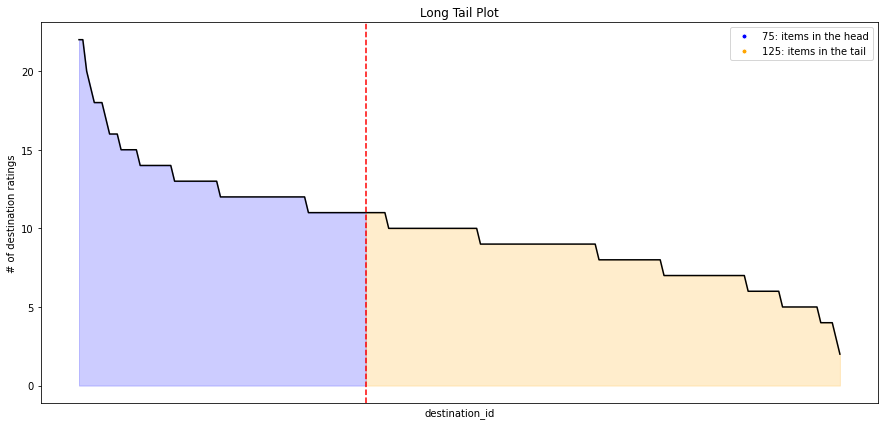

In [23]:
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="destination_id", 
             interaction_type="destination ratings", 
             percentage=0.5,
             x_labels=False)

In [24]:
# recommendation generated from the KNN generated recommendations
print(similar_ids)

[143, 168, 191, 124, 165, 131, 117, 189, 150, 155]


In [25]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['user_id', 'destination_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [26]:
test = pd.DataFrame(testset)
test.columns = ['user_id', 'destination_id', 'actual']
test.head()

,user_id,destination_id,actual
0,52,97,5.0
1,82,146,4.0
2,59,187,4.0
3,34,77,4.0
4,1,102,3.0


In [27]:
test = test.copy().groupby('user_id', as_index=False)['destination_id'].agg({'actual': (lambda x: list(set(x)))})
test

,user_id,actual
0,0,"[64, 90, 40, 47, 145, 23, 122, 28]"
1,1,"[102, 12, 113, 17, 115, 184, 25]"
2,2,"[27, 70]"
3,3,"[32, 170, 42, 77, 112, 117, 151, 125, 30]"
4,4,"[78, 50, 182, 29, 62]"
...,...,...
96,96,"[197, 74, 106, 87, 120, 185]"
97,97,"[107, 49, 139, 116]"
98,98,"[42, 87, 86, 159]"
99,99,[163]


In [28]:
print(test['actual'].isnull().sum())

0


In [29]:
test = test.set_index("user_id")
test

,actual
user_id,
0,"[64, 90, 40, 47, 145, 23, 122, 28]"
1,"[102, 12, 113, 17, 115, 184, 25]"
2,"[27, 70]"
3,"[32, 170, 42, 77, 112, 117, 151, 125, 30]"
4,"[78, 50, 182, 29, 62]"
...,...
96,"[197, 74, 106, 87, 120, 185]"
97,"[107, 49, 139, 116]"
98,"[42, 87, 86, 159]"


In [30]:
# find the recommended 10 destinations to the users of the test dataset
# and add them to a superlist
super_recommended_ids=[]
for user in test.index:
    most_recent_destination_id=test.loc[user]['actual'][-1] #extract the most recently rated destination id
    recommeneded_ids = find_similar_destinations(most_recent_destination_id, X, k=10, metric="euclidean")
    super_recommended_ids.append(recommeneded_ids)
print(super_recommended_ids)

[[127, 131, 168, 143, 133, 186, 144, 48, 165, 160], [165, 131, 143, 184, 113, 119, 51, 144, 186, 189], [110, 143, 165, 192, 131, 148, 54, 144, 186, 171], [136, 25, 165, 119, 172, 150, 198, 157, 190, 191], [122, 78, 143, 182, 180, 108, 20, 111, 152, 123], [191, 143, 124, 131, 165, 193, 189, 150, 134, 132], [144, 131, 165, 182, 143, 140, 193, 119, 157, 152], [131, 143, 160, 164, 144, 165, 119, 182, 113, 105], [136, 25, 165, 119, 172, 150, 198, 157, 190, 191], [172, 183, 169, 105, 143, 156, 101, 131, 86, 133], [184, 195, 143, 132, 131, 165, 137, 51, 113, 150], [193, 150, 144, 188, 186, 131, 175, 113, 140, 155], [151, 94, 39, 177, 131, 25, 161, 186, 118, 71], [150, 163, 155, 71, 193, 162, 161, 188, 111, 31], [130, 157, 171, 154, 121, 147, 159, 5, 177, 136], [156, 184, 193, 131, 143, 168, 144, 165, 132, 71], [132, 186, 131, 116, 191, 160, 168, 165, 143, 130], [131, 160, 129, 143, 188, 162, 191, 152, 144, 165], [174, 144, 131, 192, 51, 162, 186, 180, 193, 124], [186, 131, 143, 108, 175, 193,

In [31]:
# update the recommended ids as a new column
test['collab_predictions']=super_recommended_ids
test.head()

,actual,collab_predictions
user_id,,
0,"[64, 90, 40, 47, 145, 23, 122, 28]","[127, 131, 168, 143, 133, 186, 144, 48, 165, 160]"
1,"[102, 12, 113, 17, 115, 184, 25]","[165, 131, 143, 184, 113, 119, 51, 144, 186, 189]"
2,"[27, 70]","[110, 143, 165, 192, 131, 148, 54, 144, 186, 171]"
3,"[32, 170, 42, 77, 112, 117, 151, 125, 30]","[136, 25, 165, 119, 172, 150, 198, 157, 190, 191]"
4,"[78, 50, 182, 29, 62]","[122, 78, 143, 182, 180, 108, 20, 111, 152, 123]"


In [32]:
actual=test['actual'].values.tolist()
collab_predictions=test['collab_predictions'].values.tolist()
print(actual)
print(collab_predictions)

[[64, 90, 40, 47, 145, 23, 122, 28], [102, 12, 113, 17, 115, 184, 25], [27, 70], [32, 170, 42, 77, 112, 117, 151, 125, 30], [78, 50, 182, 29, 62], [101, 9, 75, 107, 178], [192, 162, 166, 135, 169, 170, 137], [169, 59, 172, 16, 123], [161, 2, 67, 163, 165, 4, 9, 171, 15, 80, 148, 88, 30], [9, 10, 74, 177, 146, 59], [96, 137, 66, 42], [171, 142, 20, 85, 158], [41, 112, 81, 52, 153, 126, 63], [136, 170, 13, 81, 57], [56, 66], [88, 197], [197, 103, 169, 18, 83, 148], [20, 39, 166, 151], [13, 146, 19, 52, 89, 26], [77, 118], [161, 99, 199, 17, 57, 63], [160, 103, 109, 58, 92], [104, 170, 14], [80, 104, 79], [8, 152, 181, 191], [56, 155], [2, 38, 178, 119, 121], [170, 69, 53, 158], [64, 145, 84, 168], [43, 108, 179, 116, 126], [99, 73, 75, 21, 56, 92, 31], [193, 105, 47, 111, 17, 62], [6, 104, 73, 138, 25, 58], [3, 106, 142, 181, 121, 157, 25], [65, 3, 77, 177, 119, 57, 94, 159], [40, 104, 76, 184, 122], [99, 43, 93, 148, 123, 125], [64, 98, 75, 139, 184, 125], [135, 168, 139, 49, 21], [74, 

In [33]:
# calculate the mark score
collab_mark = []
for K in np.arange(1, 11):
    collab_mark.extend([recmetrics.mark(actual, collab_predictions, k=K)])
collab_mark

[0.003630363036303631,
 0.006600660066006602,
 0.0076796141152576805,
 0.009435861168534435,
 0.010181650033135183,
 0.010456677535885459,
 0.011918252264786919,
 0.012949605400100449,
 0.013407984571350907,
 0.014020903006051523]

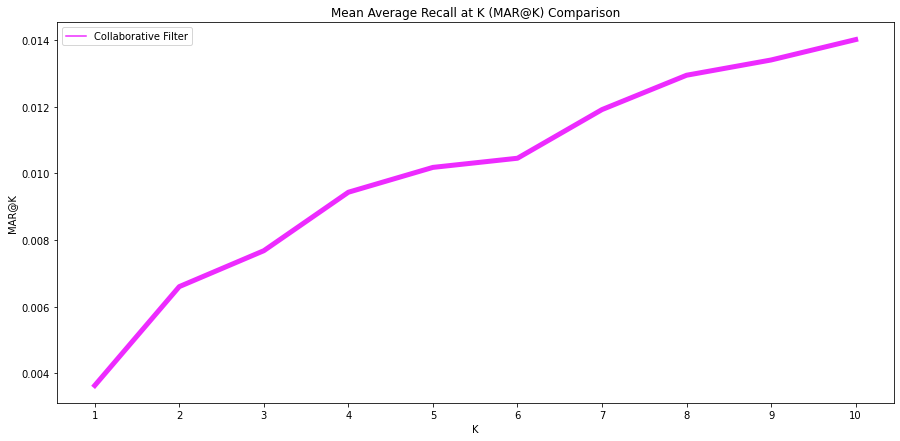

In [34]:
# generate a mark plot
mark_scores = [collab_mark]
index = range(1,10+1)
names = ['Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

In [35]:
import ml_metrics as metrics

### Similarly, generate MAPK score

In [36]:
collab_mapk = []
for K in np.arange(1, 11):
    collab_mapk.extend([metrics.mapk(actual, collab_predictions, k=K)])
collab_mapk

[0.019801980198019802,
 0.017326732673267328,
 0.01375137513751375,
 0.012788778877887787,
 0.011584158415841586,
 0.011056105610561057,
 0.012238723872387239,
 0.013175781863900676,
 0.013560820367751062,
 0.014115066268531618]

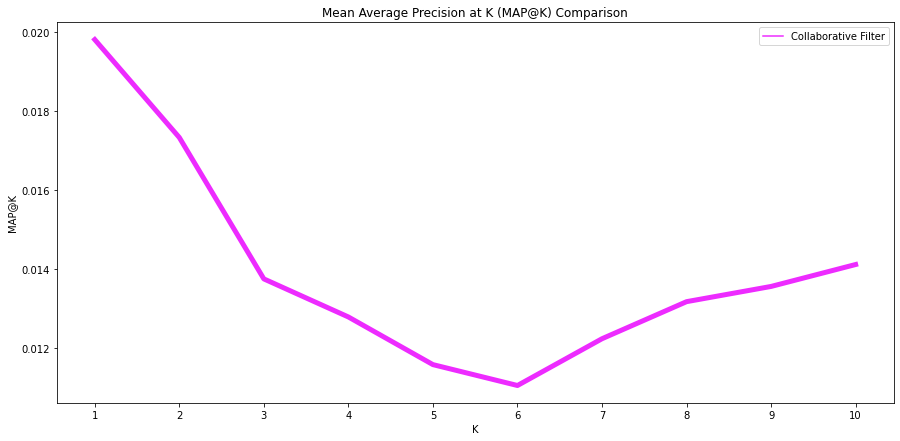

In [37]:
# generate a mapk plot
mapk_scores = [collab_mapk]
index = range(1,10+1)
names = ['Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.mapk_plot(mapk_scores, model_names=names, k_range=index)

## Calculate the prediction coverage

In [42]:
catalog = ratings.destination_id.unique().tolist()
collab_coverage = recmetrics.prediction_coverage(collab_predictions, catalog)
print(collab_coverage)

52.0


## Coverage plot

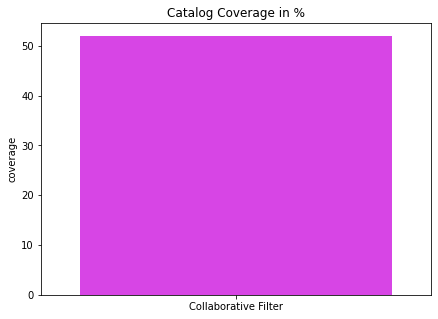

In [39]:
# plot of prediction coverage
coverage_scores = [collab_coverage]
model_names = ['Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

## Intra-list similarity

In [40]:
feature_df=destinations[['history','art_and_architecture','nature','adventure', 'entertainment','health_and_lifestyle',\
                        'food','industries','religious']]
feature_df

,history,art_and_architecture,nature,adventure,entertainment,health_and_lifestyle,food,industries,religious
0,True,True,False,False,False,False,False,False,True
1,False,False,True,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False
3,True,True,False,False,False,False,False,False,True
4,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
195,True,True,True,False,False,False,False,False,False
196,True,True,True,False,False,False,False,False,False
197,True,True,False,False,False,False,False,False,True
198,False,False,False,False,True,False,False,False,False


In [41]:
recmetrics.intra_list_similarity(collab_predictions, feature_df)

0.3708347278418736